# Differential reddening correction of Terzan 5
Research project for the course of **Stellar Astrophysics**. 

**Students**: Aggio Giada (2089092), Boscato Marco (2096921), Merola Mattia (2090208)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget

## The reddenened CMD
We read the data and select only the ones that don't present saturated values. 

In [2]:
df = pd.read_fwf('./data/Ter5xymag.txt', delimiter='')

Flag the values with errors (like mag 99.999, saturated).

In [3]:
# add new column of ones as flag
flag = np.ones(len(df))
df['flag'] = flag

# change flag to 0 if F606W or F814W is saturated
df.loc[(df['F606W'] > 99) | (df['F814W'] > 99), 'flag'] = 0

data = df[df['flag' ]== 1.0]
data = data.drop(columns=['flag'])

data.head()


,X,Y,F606W,F814W
0,2630.52,3907.54,27.2402,22.3182
1,2652.88,3909.42,26.8100,23.6855
2,2600.77,3916.65,21.4564,18.1027
3,2983.68,3918.88,26.0843,23.2045
4,3014.33,3924.09,20.9049,17.8498


In [4]:
# Terzan 5
data['Color'] = data['F606W'] - data['F814W']
data['Magnitude'] = data['F814W']

data.head()

,X,Y,F606W,F814W,Color,Magnitude
0,2630.52,3907.54,27.2402,22.3182,4.9220,22.3182
1,2652.88,3909.42,26.8100,23.6855,3.1245,23.6855
2,2600.77,3916.65,21.4564,18.1027,3.3537,18.1027
3,2983.68,3918.88,26.0843,23.2045,2.8798,23.2045
4,3014.33,3924.09,20.9049,17.8498,3.0551,17.8498


Plot the CMD affected by reddening. 

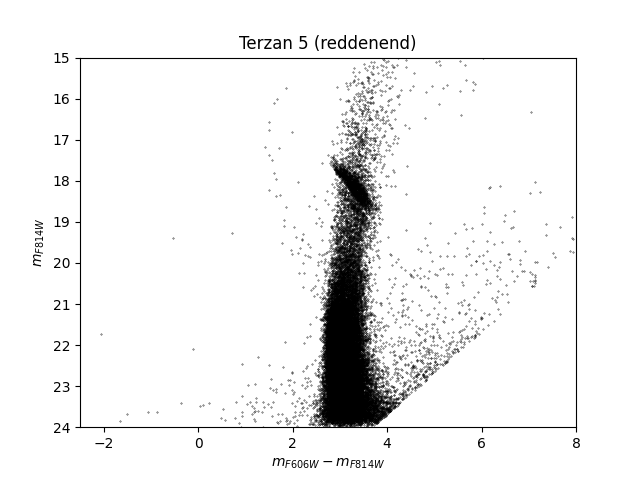

In [5]:
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='black')
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Terzan 5 (reddenend)')
plt.show()

From this CMD we see that Terzan 5 is strongly affected by differential reddening. Since it is located behind the bulge, there is an high probability of contamination so we need to use proper motions to differentiate between stars belonging to the cluster and field stars. However, since we want to do this analysis based only on the dataset we have, we skip this passage. 

----

## Differential reddening correction: Red Clump method
### Reddening Vector
Here we use the procedure and the values described in [Massari et. al 2012](https://iopscience.iop.org/article/10.1088/2041-8205/755/2/L32/pdf). 
We know that $R_I = A_I/E(B-V)$ and $R_V = A_V/E(B-V)$

The slope of the reddening vector is given by 
$$
\text{Slope} = \frac{R_I}{R_V-R_I}
$$

The slope indicates the direction and magnitude of the shift in the CMD due to the reddening. 

In [6]:
R_V = 2.83          # R_F606W
R_I = 1.82          # R_F814W

# plot the reddening vector
slope = (R_I)/(R_V-R_I)

color_0 = 4
mag_0 = 20

lenght = 1                          # lenght of the reddening vector

delta_mag = lenght
delta_col = delta_mag/slope

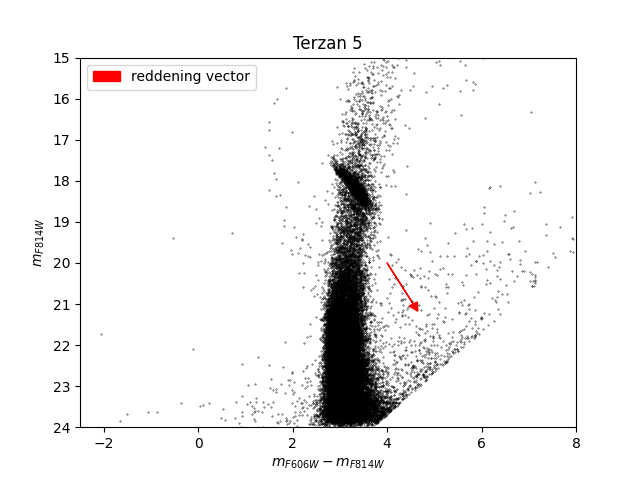

In [7]:
# plot reddening vector as an arrow
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='black')
plt.arrow(color_0, mag_0, delta_col, delta_mag, head_width=0.2, head_length=0.2, fc='red', ec='red', label='reddening vector')
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('Terzan 5')
plt.show()

### Red Clump
Since Terzan 5 young and metal rich and for this reason its CMD is characterized by the presence of the Red Clump, we can use this feature to compute the differential reddening. In the CMD of this GC, however we have that the Red Clump may be mixed up with the RGB Bump. Even though we can see the presence of the Red Clump just looking at the CMD we can try to plot an histogram to verify its presence. 

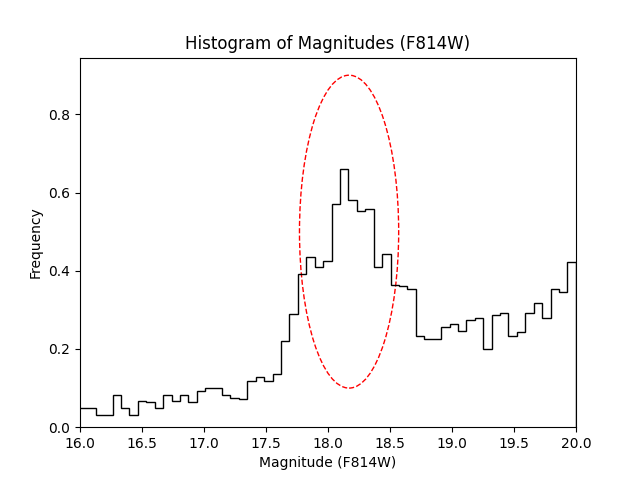

In [8]:
# Extract the F606W magnitudes
mag = np.where(data['F814W'] > 16, data['F814W'], np.nan)
magnitudes = np.where(data['F814W'] < 20, data['F814W'], np.nan)

# Create the histogram
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(magnitudes, bins=100, color='black', density=True, histtype='step')    

# Define the circle parameters
circle_radius = 0.4
circle_x = 18.17  # x-coordinate of the circle's center
circle_y = 0.5  # y-coordinate of the circle's center (height of the histogram bar)

# Create and add the circle
circle = plt.Circle((circle_x, circle_y), circle_radius, color='red', fill=False, linewidth=1, linestyle='dashed')
ax.add_patch(circle)

# Display the plot
plt.xlim(20, 16)
plt.gca().invert_xaxis()
plt.xlabel('Magnitude (F814W)')
plt.ylabel('Frequency')
plt.title('Histogram of Magnitudes (F814W)')
plt.show()

### Reddening correction
The methodology that will be employed involves dividing the field of view into a specified number of sectors and then computing the CMD for each sector. Then we select the region of the CMD in which we have the Red Clump, and the we plot the mean point of this region for each sector. Subsequently, the sector exhibiting the lowest standard deviation is selected as a reference since it should be the sector with the lowest reddening, and the difference between the mean point of each sector and the mean point of the reference sector is computed. At this point, we have the color and magnitude excess, which allows us to correct the entire CMD. 

We start by dividing the CMD into sectors.

In [9]:
n_sectors_x = 30  # Number of sectors along x
n_sectors_y = 30  # Number of sectors along y
x_bins = np.linspace(data['X'].min(), data['X'].max(), n_sectors_x+1)
y_bins = np.linspace(data['Y'].min(), data['Y'].max(), n_sectors_y+1)

# assign a sector to each data point
data['Sector'] = -1
sector_colors = []

for i in range(n_sectors_x):
    for j in range(n_sectors_y):
        sector_index = i * n_sectors_y + j
        sector_colors.append(sector_index)
        sector_data = (data['X'] >= x_bins[i]) & (data['X'] < x_bins[i+1]) & \
                      (data['Y'] >= y_bins[j]) & (data['Y'] < y_bins[j+1])
        data.loc[sector_data, 'Sector'] = sector_index

data.head()


,X,Y,F606W,F814W,Color,Magnitude,Sector
0,2630.52,3907.54,27.2402,22.3182,4.9220,22.3182,0
1,2652.88,3909.42,26.8100,23.6855,3.1245,23.6855,0
2,2600.77,3916.65,21.4564,18.1027,3.3537,18.1027,0
3,2983.68,3918.88,26.0843,23.2045,2.8798,23.2045,60
4,3014.33,3924.09,20.9049,17.8498,3.0551,17.8498,60


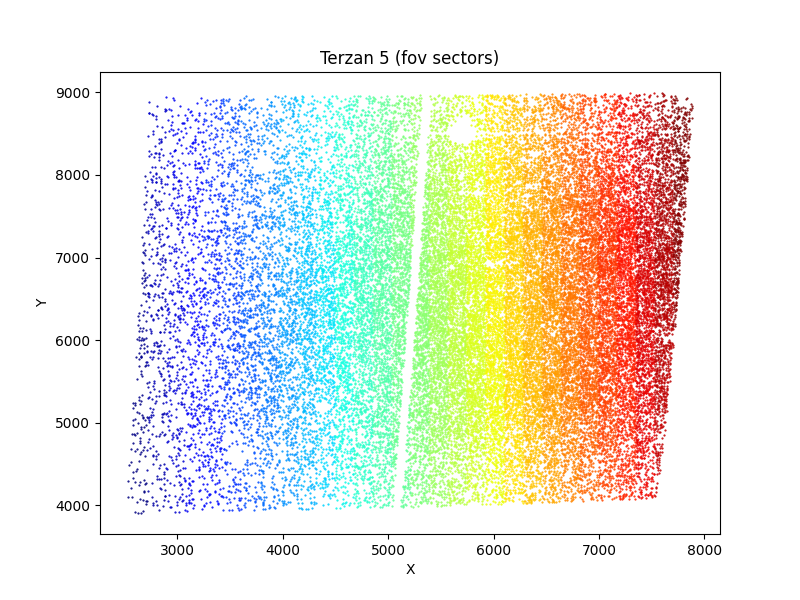

In [10]:
# plot the sensor sectors with different colors
plt.figure(figsize=(8, 6))
colors = plt.cm.jet(np.linspace(0, 1, n_sectors_x * n_sectors_y))

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['X'], sector_data['Y'], color=colors[sector_index], s=0.3, label=f'Sector {sector_index}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Terzan 5 (fov sectors)')
plt.show()

Now that the sensor is divided in sector we plot the CMD for each sector (in the same plot, the color of the CMD is the same as the sector in the sensor).

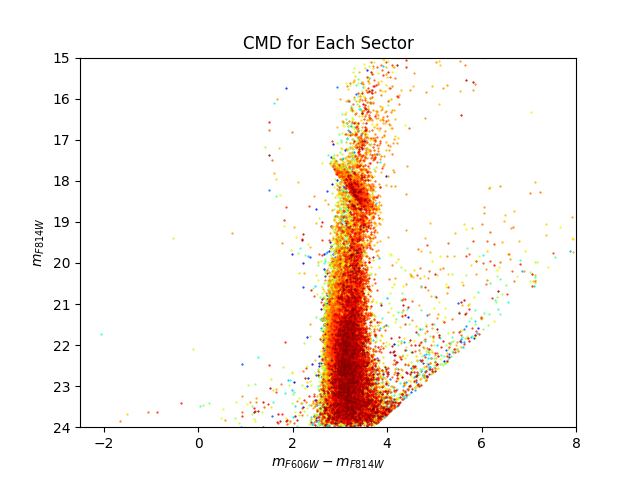

In [11]:
# plot the CMD for all sectors on the same figure
plt.figure()

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'], sector_data['F814W'], color=colors[sector_index], s=0.3)

plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('CMD for Each Sector')
plt.show()

Now for each sector we select the red clump stars (the ones inside the rectangle in the plot) and compute the mean point. At the end of this operation we'll have $N\times N$ points (where $N$ is the number of sectors along the $x$ an $y$ axis) representing the mean point of each red clump of each sector. 

In [12]:
# Select Red Clump (RC) stars
slope = np.array([1.125, -1.125])
intercept = []
intercept.append(24 - slope[0]*8.2)
intercept.append(24 - slope[0]*8.8)
intercept.append(24 - slope[1]*(-0.6))
intercept.append(21 - slope[1]*(-0.5))
intercept = np.array(intercept)

rc_data = data[ ( data['F814W'] <= slope[0]*(data['F606W'] - data['F814W']) + intercept[0])                      #above the left oblique line
            &   ( data['F814W'] >= slope[0]*(data['F606W'] - data['F814W']) + intercept[1])     
            &   ( data['F814W'] <= slope[1]*(data['F606W'] - data['F814W']) + intercept[2])    
            &   ( data['F814W'] >= slope[1]*(data['F606W'] - data['F814W']) + intercept[3])] 

Let's plot our CMD highlighting the stars of the red clump to check if our selection is reliable. 

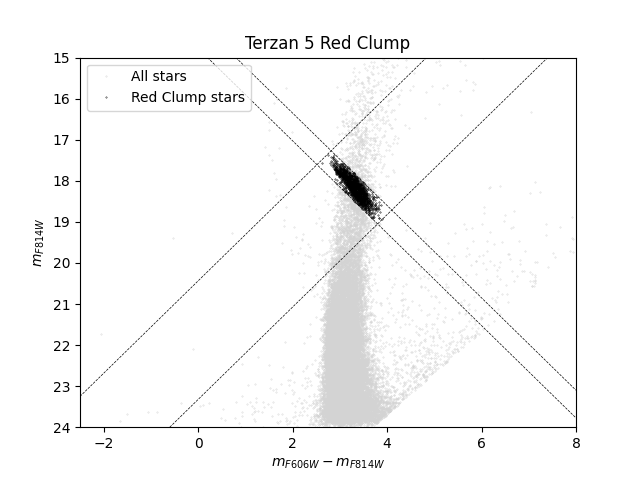

In [13]:
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='lightgrey', label='All stars')
plt.plot(rc_data['Color'], rc_data['Magnitude'], 'o', markersize=0.3, color='black', label='Red Clump stars')

# red clump region for Terzan 5
plt.axline((8.2, 24.), slope=1.125, color='black', linestyle='--', linewidth=0.5)
plt.axline((8.8, 24.), slope=1.125, color='black', linestyle='--', linewidth=0.5)
plt.axline((-0.6, 24.), slope=-1.125, color='black', linestyle='--', linewidth=0.5)
plt.axline((-0.5, 21), slope=-1.125, color='black', linestyle='--', linewidth=0.5)

plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('Terzan 5 Red Clump')
plt.show()

Now for each sector we compute the mean point for the selected area. At the end of this operation we'll have $N\times N$ points (where $N$ is the number of sectors along the $x$ an $y$ axis) representing the mean point of each red clump of each sector. 

In [14]:
# Calculate the mean point of RC stars for each sector
mean_points = []
color_excesses = []
mag_excesses = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_rc_data = rc_data[rc_data['Sector'] == sector_index]
    if not sector_rc_data.empty:
        mean_color = (sector_rc_data['F606W'] - sector_rc_data['F814W']).mean()
        mean_mag = sector_rc_data['F814W'].mean()
        mean_points.append((mean_color, mean_mag))
    else:
        mean_points.append((np.nan, np.nan))


Now we look for the sector with the lowest standard deviation and we take it as a reference sector (the position of the mean point is the best approximation of all the point, so this sector represent the one less affected by reddening). 

In [15]:
# compute the sector with the lowest standard deviation
stds = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_rc_data = rc_data[rc_data['Sector'] == sector_index]
    if not sector_rc_data.empty:
        std = (sector_rc_data['F606W']-sector_rc_data['F814W']).std()
        stds.append(std)
    else:
        stds.append(np.nan)

min_std_sector = np.nanargmin(stds)
print(f'Sector with the lowest standard deviation: {min_std_sector}')

Sector with the lowest standard deviation: 437


Now we compute, for each sector, the difference between its mean point and the mean point of the reference sector. This difference represent the **color excess** and the **magnitude excess**. 

Once we have done that we can plot the **corrected CMD** simply subtracting the color excess and the mag excess from the color index and the magnitude, respectively.

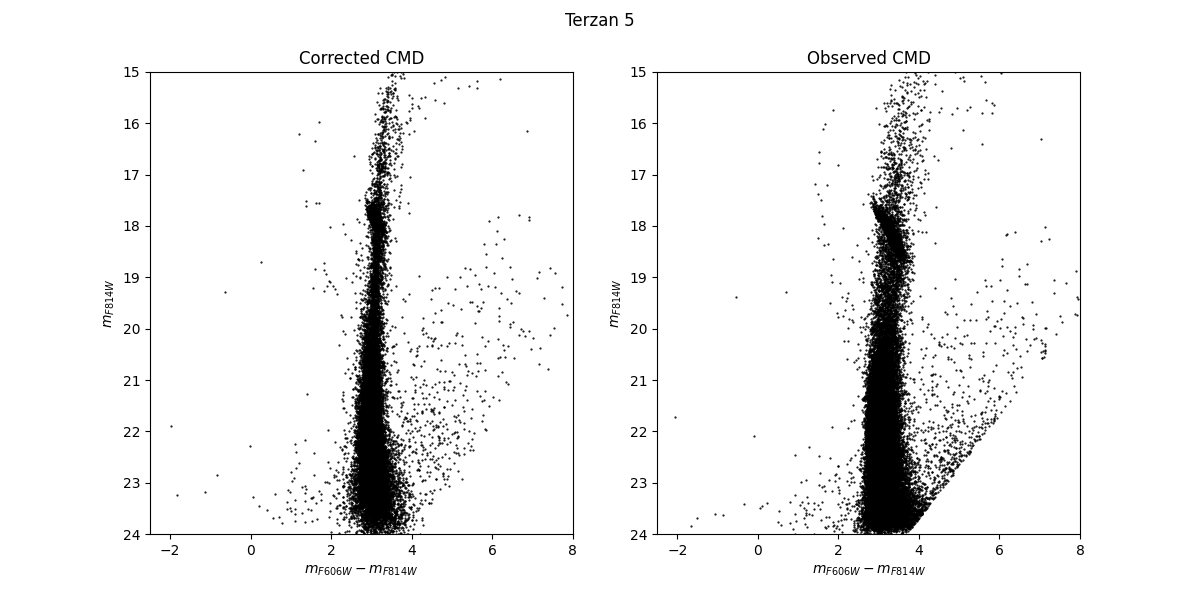

In [16]:
# compute for each sector the difference between the mean point and the minimum standard deviation sector
for sector_index in range(n_sectors_x * n_sectors_y): 
    color_excess = mean_points[sector_index][0] - mean_points[min_std_sector][0]
    mag_excess = mean_points[sector_index][1] - mean_points[min_std_sector][1]
    color_excesses.append(color_excess)
    mag_excesses.append(mag_excess)

# plot the CMD for all sectors on the same figure
plt.figure(figsize=(12,6))
plt.suptitle('Terzan 5')

plt.subplot(121)
for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color='black', s=0.3)
    
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Corrected CMD')

plt.subplot(122)
plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3)
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Observed CMD')

plt.show()


To see the difference between the corrected CMD and the original one we can plot them in the same figure. The black CMD is the original one, the colored one is the corrected.  

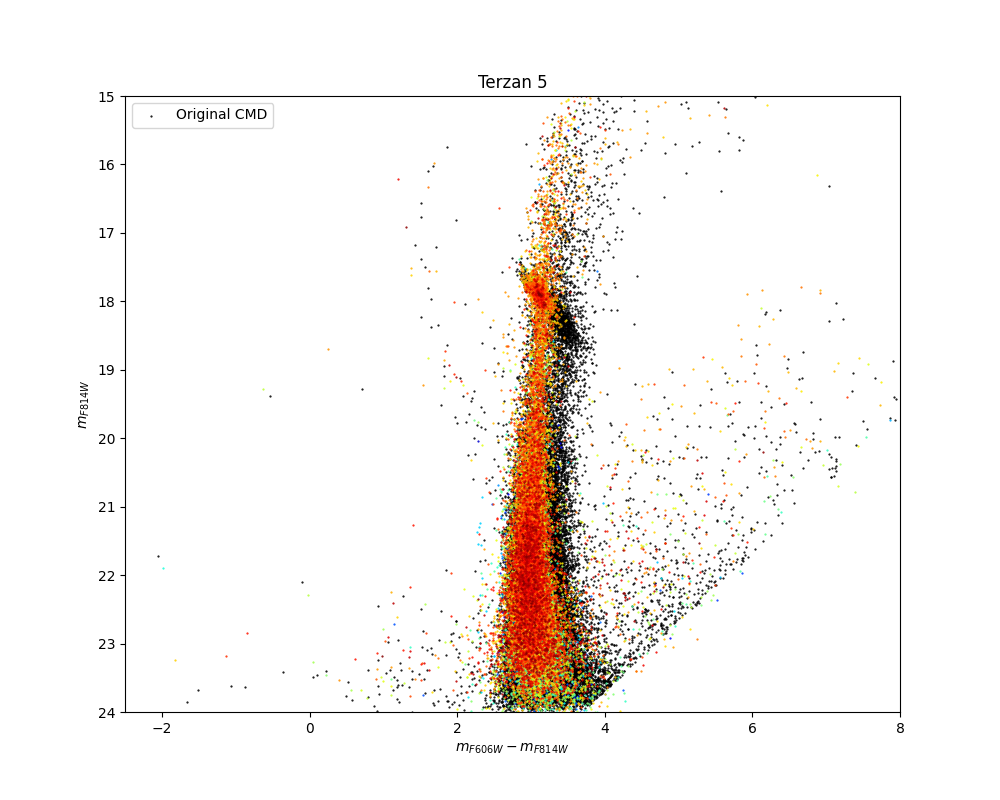

In [17]:
# compare the corrected CMD with the one affected by differential reddening on the same plot
plt.figure(figsize=(10, 8))

plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3, label='Original CMD')

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color=colors[sector_index], s=0.3)
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend()
plt.title('Terzan 5')
plt.show()



This method provides a good differential reddening correction, however takes a lot of computational time and needs some adjustments to be easily applicable to other CMDs since in our work we selected the red clump visually, using lines that are correct only for this specific case and we didn't apply any statistical tool. In addiciton, since this method completely relies on the presence of the Red Clump, it can be applyed only to young and metal rich populations since old clusters do not present the Red Clump.

In absence of the RC we have to use other methods, for example plotting fiducial lines for determined sequence and then correcting for differential reddening using these lines.

Moreover in this work we didn't consider the contamination of the field due to stars belonging to the galactic bulge so it is not a perfect correction.  

----

## Differential reddening correction: MS slit method

We can use the same reddening method used to analyze M22, which consists basically in doing the same procedure we have done before but considering a small region in the Main Sequence. 

First of all we select the region we are going to work with. 

In [18]:
mag_lo = 23.3
mag_hi = 23.6
col_lo = 2.4
col_hi = 4

ms_data = data[(data['F814W'] > mag_lo)
             & (data['F814W'] < mag_hi)
             & (data['F606W'] - data['F814W'] > col_lo) 
             & (data['F606W'] - data['F814W'] < col_hi)]

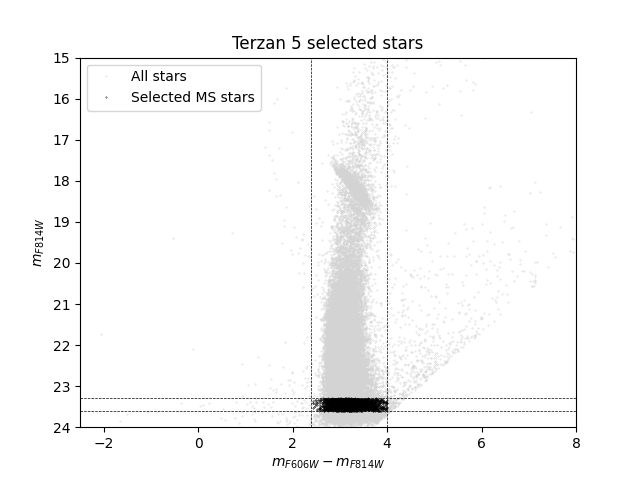

In [19]:
plt.figure()
plt.plot(data['Color'], data['Magnitude'], 'o', markersize=0.3, color='lightgrey', label='All stars')
plt.plot(ms_data['Color'], ms_data['Magnitude'], 'o', markersize=0.3, color='black', label='Selected MS stars')
plt.axhline(y=mag_lo, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=mag_hi, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=col_lo, color='k', linestyle='--', linewidth=0.5)
plt.axvline(x=col_hi, color='k', linestyle='--', linewidth=0.5)

plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend(numpoints=1)
plt.title('Terzan 5 selected stars') 
plt.show()

For each sector we compute the mean point for the selected MS stars.

In [20]:
# Calculate the mean point of MS stars for each sector
mean_points_ms = []
color_excesses_ms = []
mag_excesses_ms = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_ms_data = ms_data[ms_data['Sector'] == sector_index]
    if not sector_ms_data.empty:
        mean_color_ms = (sector_ms_data['F606W'] - sector_ms_data['F814W']).mean()
        mean_mag_ms = sector_ms_data['F814W'].mean()
        mean_points_ms.append((mean_color_ms, mean_mag))
    else:
        mean_points_ms.append((np.nan, np.nan))

Now we look for the sector with the lowest standard deviation and we take it as reference sector (as done for the previous method). In our model this sector represents the one less affected by reddening.

In [21]:
# compute the sector with the lowest standard deviation
stds_ms = []

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_ms_data = ms_data[ms_data['Sector'] == sector_index]
    if not sector_ms_data.empty:
        std_ms = (sector_ms_data['F606W']-sector_ms_data['F814W']).std()
        stds_ms.append(std_ms)
    else:
        stds_ms.append(np.nan)

min_std_sector_ms = np.nanargmin(stds_ms)
print(f'Sector with the lowest standard deviation: {min_std_sector_ms}')

Sector with the lowest standard deviation: 627


At this point we compute, for each sector, the difference between its mean point and the mean point of the reference sector. This difference represent the **color excess** and the **magnitude excess**. 

Once we have done that we can plot the **corrected CMD** simply subtracting the color excess and the mag excess from the color index and the magnitude, respectively.

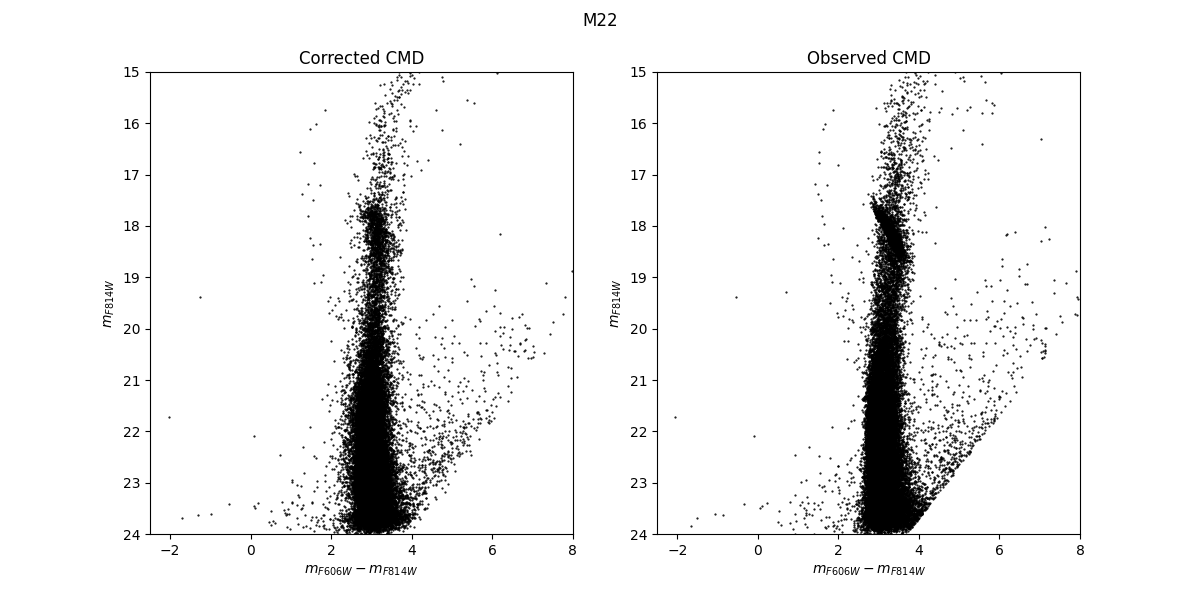

In [22]:
# compute for each sector the difference between the mean point and the minimum standard deviation sector
for sector_index in range(n_sectors_x * n_sectors_y): 
    color_excess_ms = mean_points_ms[sector_index][0] - mean_points_ms[min_std_sector_ms][0]
    mag_excess_ms = mean_points_ms[sector_index][1] - mean_points_ms[min_std_sector][1]
    color_excesses_ms.append(color_excess_ms)
    mag_excesses_ms.append(mag_excess_ms)

# plot the CMD for all sectors on the same figure
plt.figure(figsize=(12,6))
plt.suptitle('M22')

plt.subplot(121)
for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses_ms[sector_index],
                sector_data['F814W'] - mag_excesses_ms[sector_index], color='black', s=0.3)
    
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Corrected CMD')

plt.subplot(122)
plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3)
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('Observed CMD')

plt.show()

FInally, to see the difference between the corrected CMD and the original one we can plot them in the same figure. The black CMD is the original one, the colored one is the corrected.  

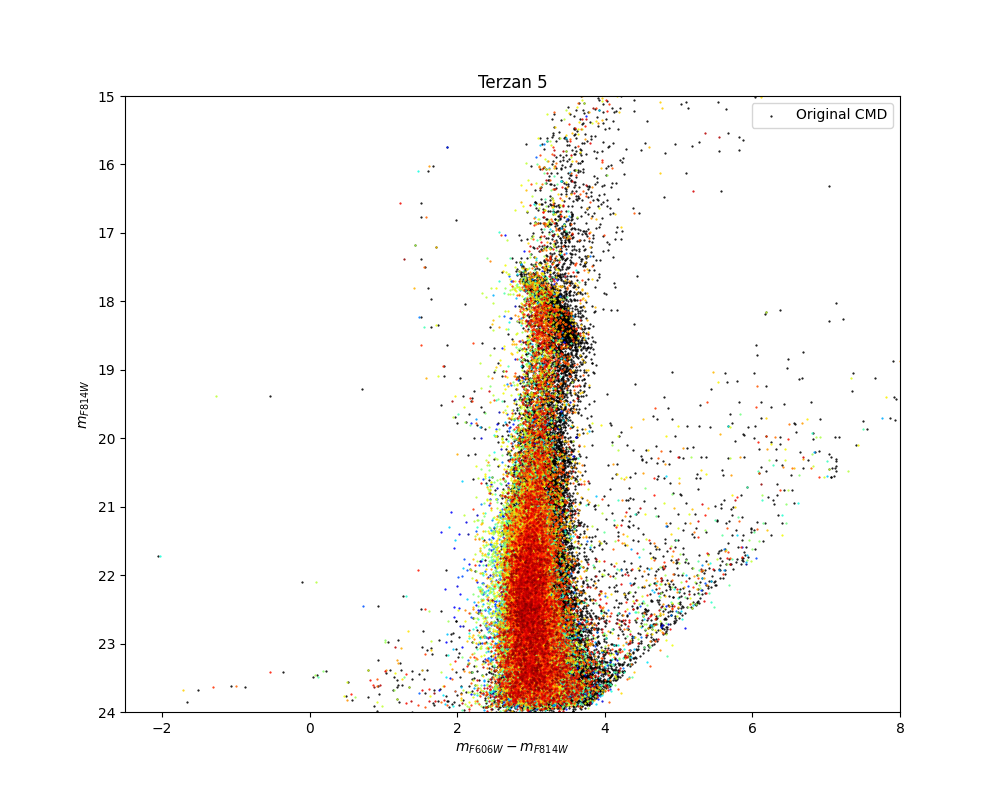

In [23]:
# compare the CMD corrected with the second method with the one affected by differential reddening on the same plot
plt.figure(figsize=(10, 8))

plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3, label='Original CMD')

for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses_ms[sector_index],
                sector_data['F814W'] - mag_excesses_ms[sector_index], color=colors[sector_index], s=0.3)
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.legend()
plt.title('Terzan 5')
plt.show()

----

## Comparison and concluding remarks
We can compare the two differential reddening correction methods.

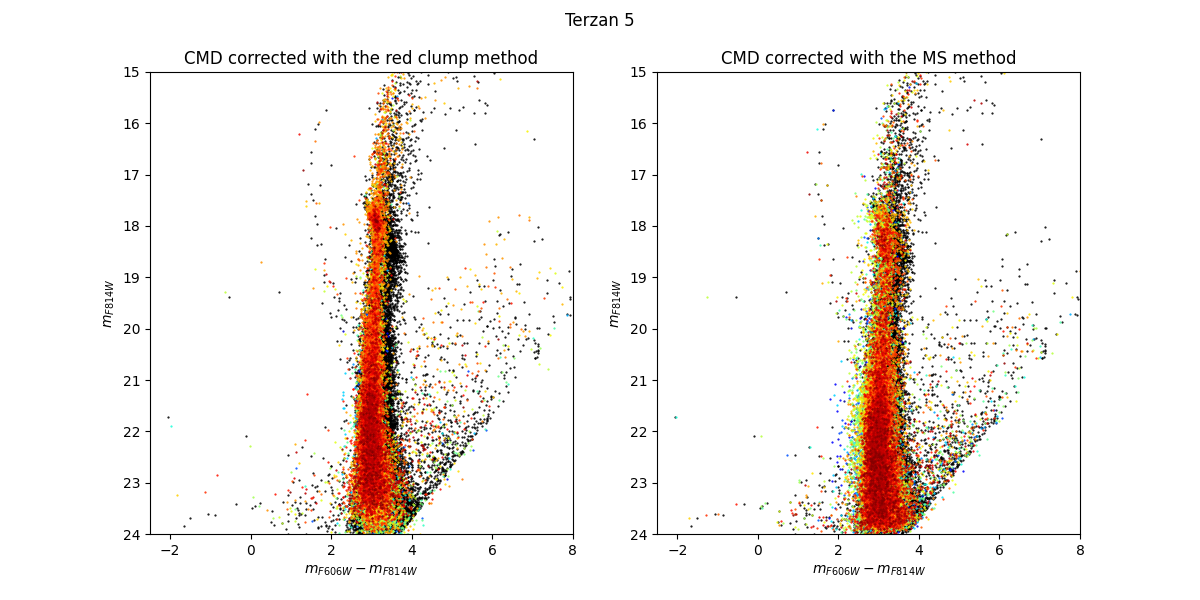

In [24]:
# Plot the two original and corrected CMBs obtained from the two methods into two subplots one beside the other

plt.figure(figsize=(12,6))
plt.suptitle('Terzan 5')

#First method
plt.subplot(121)
plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3)
for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses[sector_index],
                sector_data['F814W'] - mag_excesses[sector_index], color=colors[sector_index], s=0.3)
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('CMD corrected with the red clump method')

plt.subplot(122)
plt.scatter(data['F606W'] - data['F814W'], data['F814W'], color='black', s=0.3)
for sector_index in range(n_sectors_x * n_sectors_y):
    sector_data = data[data['Sector'] == sector_index]
    plt.scatter(sector_data['F606W'] - sector_data['F814W'] - color_excesses_ms[sector_index],
                sector_data['F814W'] - mag_excesses_ms[sector_index], color=colors[sector_index], s=0.3)
plt.gca().invert_yaxis()
plt.ylim(24, 15)
plt.xlim(-2.5,8.)
plt.xlabel(r'$m_{F606W} - m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.title('CMD corrected with the MS method')

plt.show()

It can be observed that the two corrected CMDs are coherent with respect to one another. They are translated in a similar direction in the graph and the sequences result less broadened. The most significant distinction between the two corrected plots regards the sphericity of the red clump: while the red clump method yields a more pronounced spherical shape, the MS method's sphericity is less discernible. Moreover the MS method result in a more scattered CMD which can also lead to a misinterpretation of the diagram itself. 

Obviously both methods need to be revised and improved; nevertheless, at this "state-of-the-art" point we think that the red clump method should be preferred because of the clearer sphericity of the red clump.

----